# Data Stories: A Tourist's trip in Lisbon

This section is focused on the analysis of a trip of the standard tourist in Lisbon.

We'll start by importing some dependencies:

In [3]:
# database connection library + database information
from db_configs import host, database, user, password
import psycopg2 as pg

# data manipulation libraries
import pandas as pd
import geopandas as gpd 
from shapely.geometry import Point # convert coordinates to points
import numpy as np
from datetime import datetime

# data visualization libraries
import plotly.graph_objs as go
import plotly
import cufflinks as cf # Cufflinks binds plotly to pandas dataframes in IPython notebook.
import matplotlib.pyplot as plt
import seaborn as sns # for color palettes

cf.set_config_file(offline=False, world_readable=True, theme='pearl')

# to create visualizations gifs
import glob
import os

# Turn on retina mode and set configurations
from IPython.display import set_matplotlib_formats
import IPython

set_matplotlib_formats('retina')
%matplotlib inline
plotly.offline.init_notebook_mode()
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# connect to the database
connection = pg.connect(host=host, dbname=database, user=user, password=password)

viz_out = 'plotly_viz/'

**Turista**: 5108567
<p>
chegou a dia 23 <br>
partiu a dia 30 <br>
País de origem: França



In [4]:
"""
french_story = pd.read_sql_query("SELECT * FROM telecom_pt.viz_data_stories_test",con=connection)

def number_of_days_as_float(val):
    return val.days+val.seconds/86400

french_story['stay_days'] = french_story['average_length_of_stay'].apply(number_of_days_as_float)

french_story = french_story[french_story['arrival_distrito']=='Lisboa']

days_of_stay = (french_story['stay_days']*french_story['count_arrival_concelho']).sum() / french_story['count_arrival_concelho'].sum()

days_of_stay
"""

'\nfrench_story = pd.read_sql_query("SELECT * FROM telecom_pt.viz_data_stories_test",con=connection)\n\ndef number_of_days_as_float(val):\n    return val.days+val.seconds/86400\n\nfrench_story[\'stay_days\'] = french_story[\'average_length_of_stay\'].apply(number_of_days_as_float)\n\nfrench_story = french_story[french_story[\'arrival_distrito\']==\'Lisboa\']\n\ndays_of_stay = (french_story[\'stay_days\']*french_story[\'count_arrival_concelho\']).sum() / french_story[\'count_arrival_concelho\'].sum()\n\ndays_of_stay\n'

## Getting the events for the tourist pair

In [5]:
query = """
select *
from telecom_pt.tbl_master_table
where client_id=2668548;
"""

In [6]:
couple_story = pd.read_sql_query(query,con=connection)[['event_date','client_id','centroide_latitude','centroide_longitude']]#,'distrito', 'concelho','municipio','label',]]
couple_story = couple_story[~couple_story['centroide_latitude'].isnull()]
couple_story = couple_story[~couple_story['client_id'].isnull()]
couple_story = couple_story.drop_duplicates()
couple_story['client_id'] = couple_story['client_id'].astype(int)
#couple_story['event_date'] = pd.to_datetime(couple_story['event_date'])
couple_story['day'] = couple_story['event_date'].dt.day
couple_story['hour'] = couple_story['event_date'].dt.hour
couple_story['minute'] = couple_story['event_date'].dt.minute


shp_dir = '../pt_regions_shapefiles/'
portugal = gpd.read_file(shp_dir+'gadm36_PRT.gpkg')\
            .rename(columns={'NAME_0':'country','NAME_1':'distrito', 'NAME_2':'concelho', 'NAME_3':'municipio' })\
            [['country','distrito','concelho','municipio','geometry']]


# limit area to Porto region
portugal = portugal[portugal['concelho'].isin(['Vila do Conde', 'Maia', 'Matosinhos', 'Porto', 'Vila Nova de Gaia'])]
concelhos = portugal[['concelho', 'geometry']].dissolve(by='concelho').reset_index()

# upsample data
def add_zero_and_format(val):
    if val<10:
        return '0'+str(int(val))
    else:
        return str(int(val))

couple_story = couple_story.groupby(['client_id', 'day', 'hour', 'minute']).mean().reset_index()
couple_story['date_str'] = pd.to_datetime('2017-08-'+couple_story['day'].apply(add_zero_and_format)\
                                                +' '+couple_story['hour'].apply(add_zero_and_format)+':'\
                                                    +couple_story['minute'].apply(add_zero_and_format)+':00')

couple_story = couple_story[['client_id', 'date_str','centroide_latitude','centroide_longitude']]
couple_story = couple_story.set_index('date_str')
couple_story = couple_story.groupby('client_id').resample('1T', fill_method='pad')#.asfreq().interpolate('linear')
couple_story = couple_story[['centroide_latitude','centroide_longitude']].reset_index()
couple_story = couple_story[['date_str','centroide_latitude','centroide_longitude']].groupby('date_str').mean()

In [5]:
def pd_to_gpd(df):
    geometry = [Point(xy) for xy in zip(df.centroide_longitude, df.centroide_latitude)]
    df  = df.drop(['centroide_longitude', 'centroide_latitude'], axis=1)
    crs = {'init': 'epsg:4326'}
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

couple_story = pd_to_gpd(couple_story).reset_index()
#couple_story


In [6]:
"""
def generate_frames(df, bg, directory, gif_name, alpha=1):
    
    iteration = 1
    
    def add_zero_and_format(val):
        if val<10:
            return '0'+str(int(val))
        else:
            return str(int(val))
    
    
    days = [add_zero_and_format(x) for x in list(range(min(couple_story['date_str']).day,max(couple_story['date_str']).day+1))]
    
    hours   = [add_zero_and_format(x) for x in list(range(24))]
    #minutes = [add_zero_and_format(x) for x in list(range(60))]
    
    #hours   = ['07', '8']
    minutes = ['05']
    
    total_iterations = len(days)*len(hours)*len(minutes)
    
    for day in days:
        for hour in hours:
            for minute in minutes:
                try:
                    side_length = 12
                    fig, ax1 = plt.subplots(ncols=1, figsize=(side_length, side_length), 
                                            sharex=True, sharey=True)

                    # Plot
                    bg.plot(ax=ax1, color='white', edgecolor='black')
                    df[df['date_str'] == '2017-08-%s %s:%s:00' % (day, hour, minute)] \
                                    .plot(ax=ax1, marker='o', color=['red'], markersize=60, alpha=alpha)

                    ax1.set_title('Data Story: A tourist in Lisbon', fontdict={'fontsize': 20, 'fontweight' : 3})
                    ax1.annotate('%s August 2017, %sh%sm' % (day,hour,minute), xy=(0.4, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=16, color='#555555')
                    ax1.axis('off')
                    print('Completion:',str("{0:.2f}".format((iteration/total_iterations)*100.0))+'%')
                    iteration+=1
                    plt.savefig(fname=directory+'flows_%s_story.png' % str(iteration), format='png')
                    plt.close()
                    
                except TypeError as e:
                    plt.close()
                    #print(e)
                    continue
                
    
    print('Generating GIF...')
    file_list = glob.glob(directory+'*.png') # Get all the pngs in the current directory
    list.sort(file_list, key=lambda x: int(x.split('_')[3].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
    
    with open('image_list.txt', 'w') as file:
        for item in file_list:
            file.write("%s\n" % item)
    
    os.system('convert @image_list.txt {}.gif'.format(gif_name))
    os.system('rm {}'.format('image_list.txt'))
    




# configure the generation of the visualization


generate_frames(couple_story, concelhos, 'frames_data_story/', 'data_stories_flows', alpha=1)

iframe = '<iframe src=' + 'data_stories_flows' + '.gif' + ' width=100% height=750px></iframe>'
IPython.display.HTML(iframe)
"""

'\ndef generate_frames(df, bg, directory, gif_name, alpha=1):\n    \n    iteration = 1\n    \n    def add_zero_and_format(val):\n        if val<10:\n            return \'0\'+str(int(val))\n        else:\n            return str(int(val))\n    \n    \n    days = [add_zero_and_format(x) for x in list(range(min(couple_story[\'date_str\']).day,max(couple_story[\'date_str\']).day+1))]\n    \n    hours   = [add_zero_and_format(x) for x in list(range(24))]\n    #minutes = [add_zero_and_format(x) for x in list(range(60))]\n    \n    #hours   = [\'07\', \'8\']\n    minutes = [\'05\']\n    \n    total_iterations = len(days)*len(hours)*len(minutes)\n    \n    for day in days:\n        for hour in hours:\n            for minute in minutes:\n                try:\n                    side_length = 12\n                    fig, ax1 = plt.subplots(ncols=1, figsize=(side_length, side_length), \n                                            sharex=True, sharey=True)\n\n                    # Plot\n          

## Per municipality visits

In [12]:
couple = pd.read_sql_query(query,con=connection)

couple['rel_day'] = (couple['day_of_month'] - min(couple['day_of_month'])+1).astype(int)
couple = couple[couple['municipio']!=None]
couple['municipio_from'] = couple['municipio'].shift(1)
couple['municipio_to'] = couple['municipio']
couple['arrival_date'] = couple['event_date']

couple = couple[couple['municipio_from']!=couple['municipio_to']][['client_id', 'rel_day','municipio_from', 'municipio_to']]
couple = couple[couple['municipio_from']!=None][couple['municipio_to']!=None]
couple['municipio'] = couple['municipio_to']
couple = couple[['rel_day','municipio']]

shp_dir = '../pt_regions_shapefiles/'
portugal = gpd.read_file(shp_dir+'gadm36_PRT.gpkg')\
            .rename(columns={'NAME_0':'country','NAME_1':'distrito', 'NAME_2':'concelho', 'NAME_3':'municipio' })\
            [['country','distrito','concelho','municipio','geometry']]


# limit area to Lisbon region
portugal = portugal[['municipio','geometry']][portugal['concelho'].isin(['Vila do Conde', 'Maia', 'Matosinhos', 'Porto', 'Vila Nova de Gaia'])]\


couple = portugal.merge(couple, on='municipio', how='right')
couple['rel_day2'] = couple['rel_day']
couple = couple.set_index('rel_day')


In [13]:
# PATCH
couple = couple.append(couple.loc[2])
couple.loc[2]

municipio                                           geometry  \
rel_day                                                                   
2        São Nicolau  (POLYGON ((-8.614723205566406 41.1428947448730...   
2        São Nicolau  (POLYGON ((-8.614723205566406 41.1428947448730...   

         rel_day2  
rel_day            
2               2  
2               2

In [14]:
couple.index.unique()

Int64Index([8, 1, 2, 3, 4, 5, 6, 7], dtype='int64', name='rel_day')

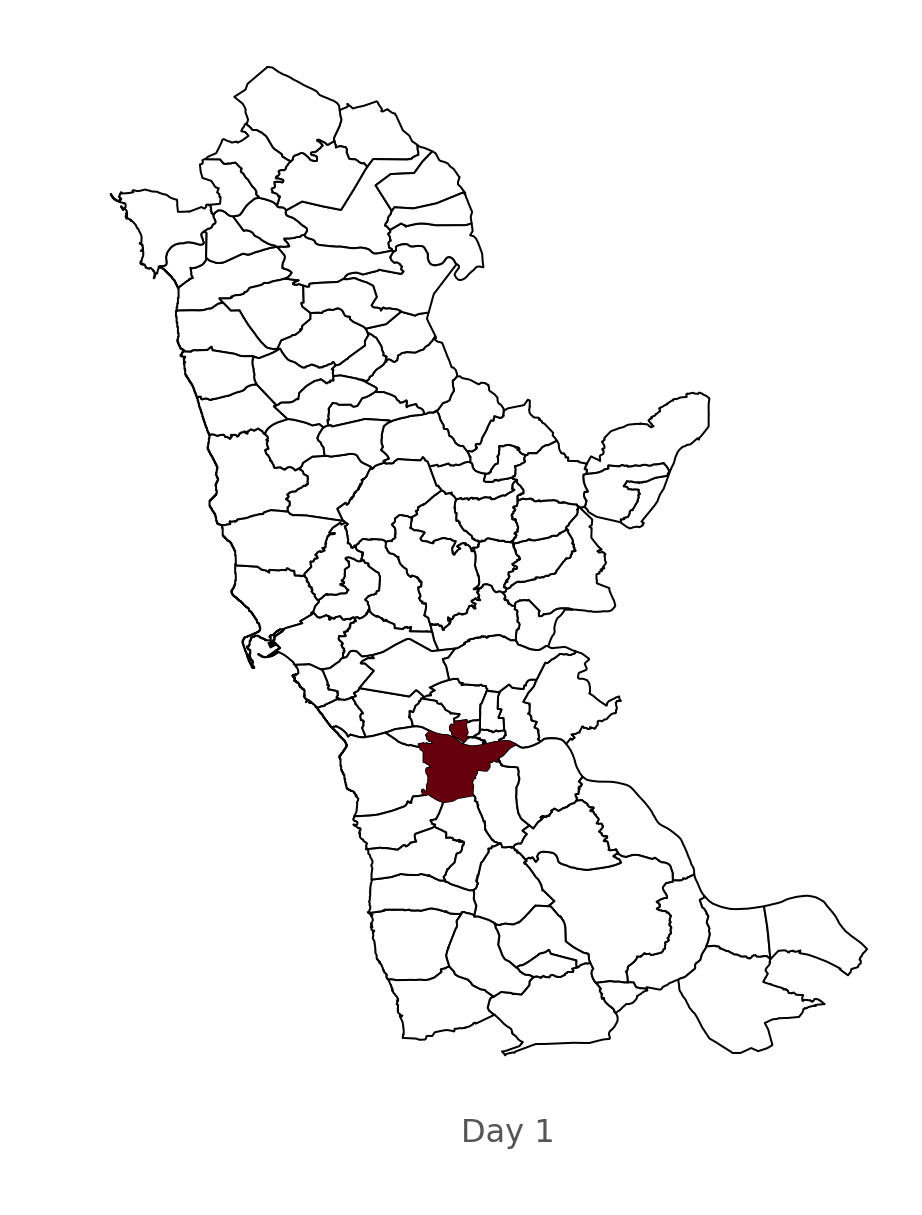

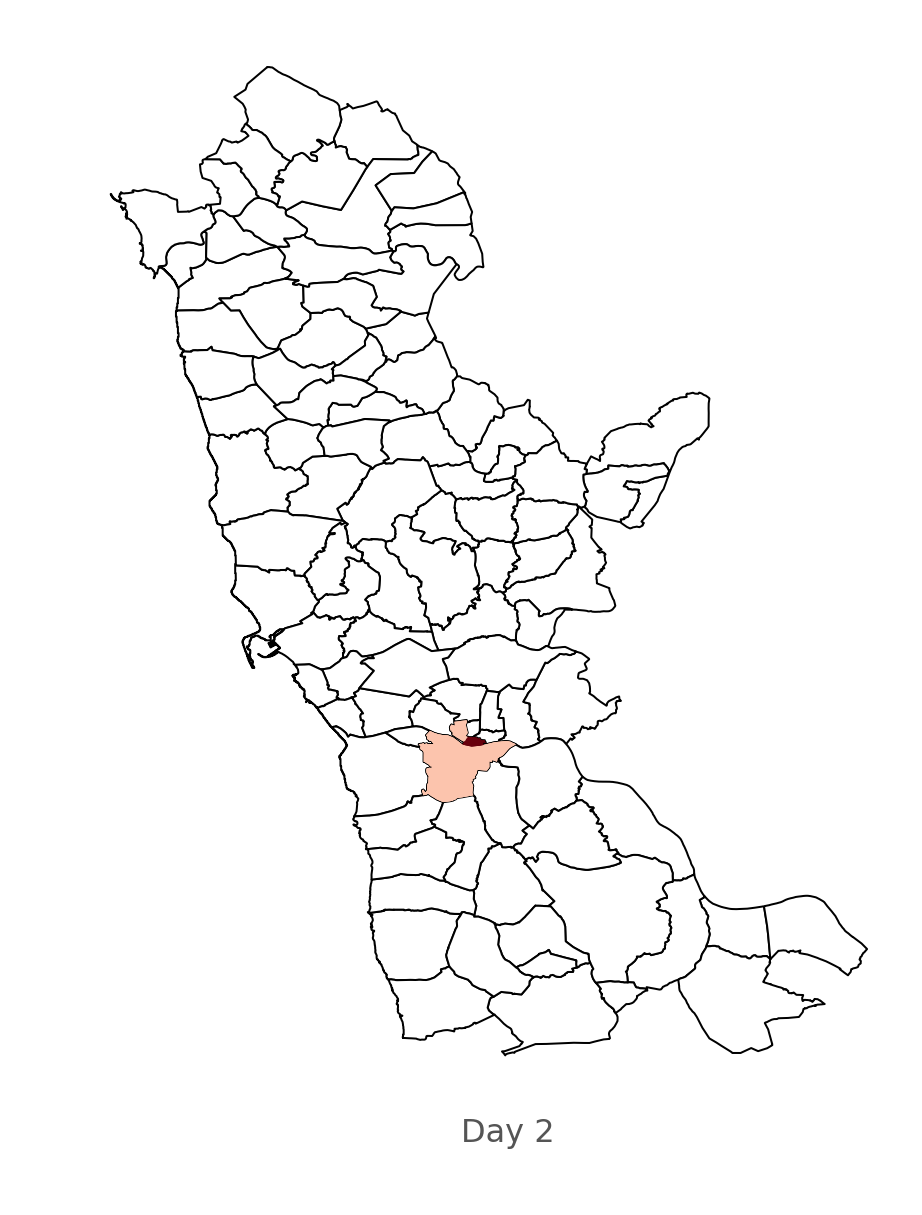

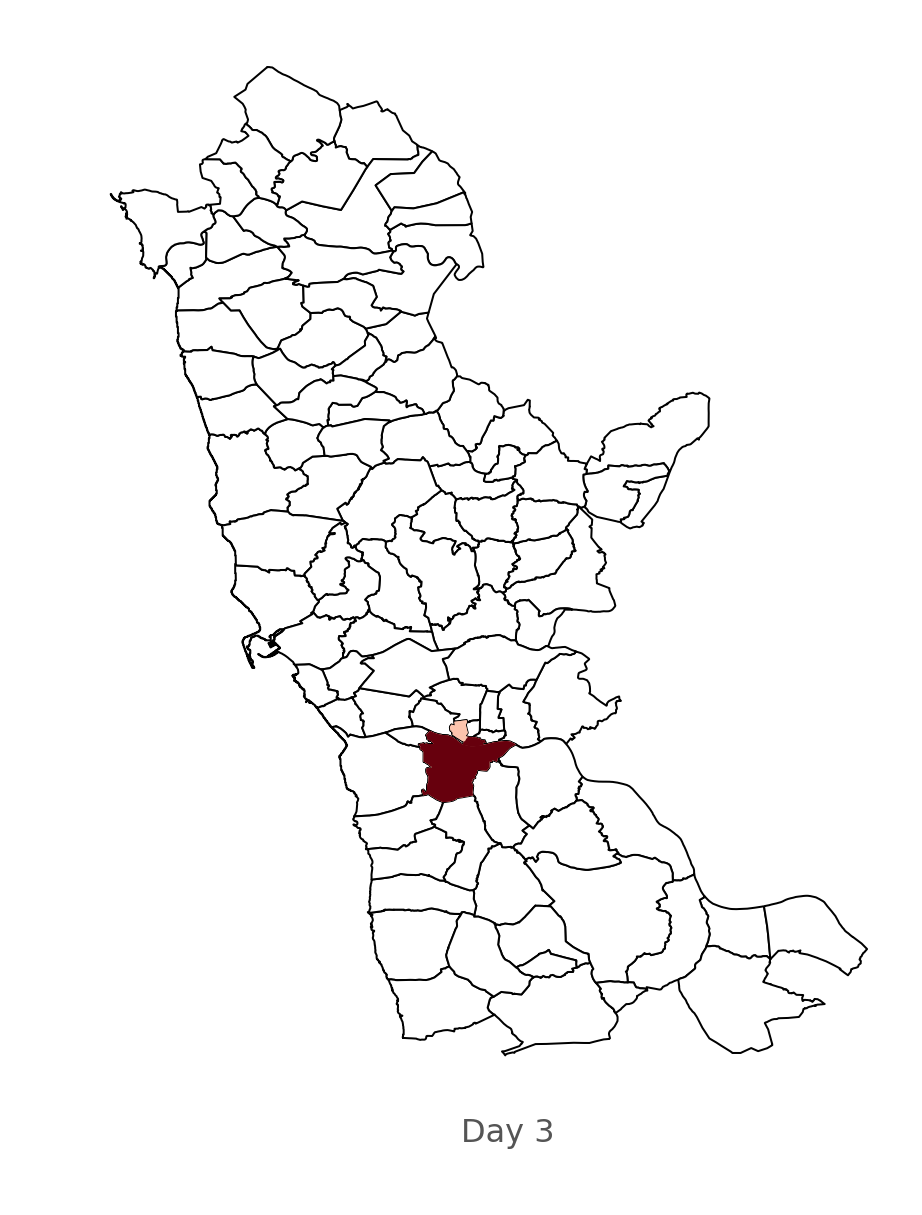

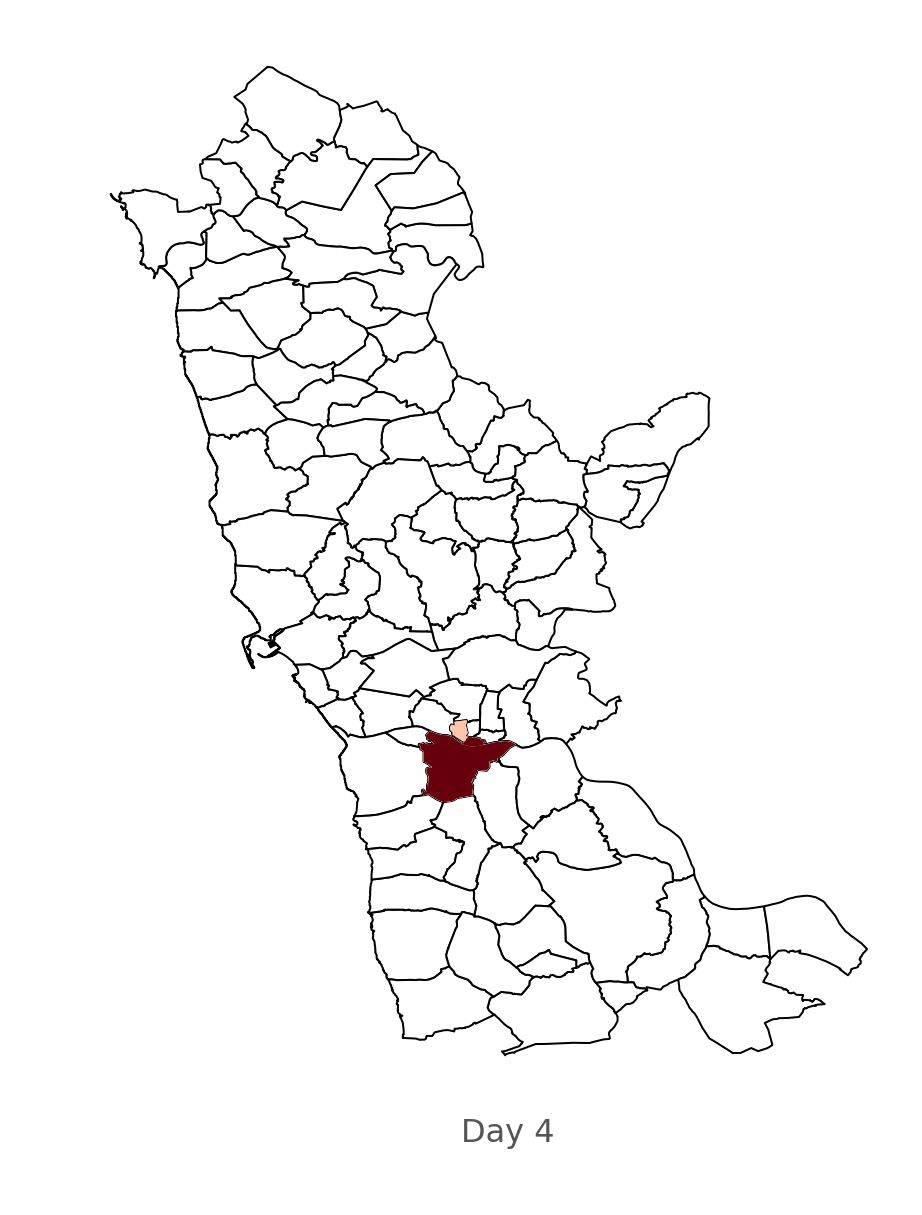

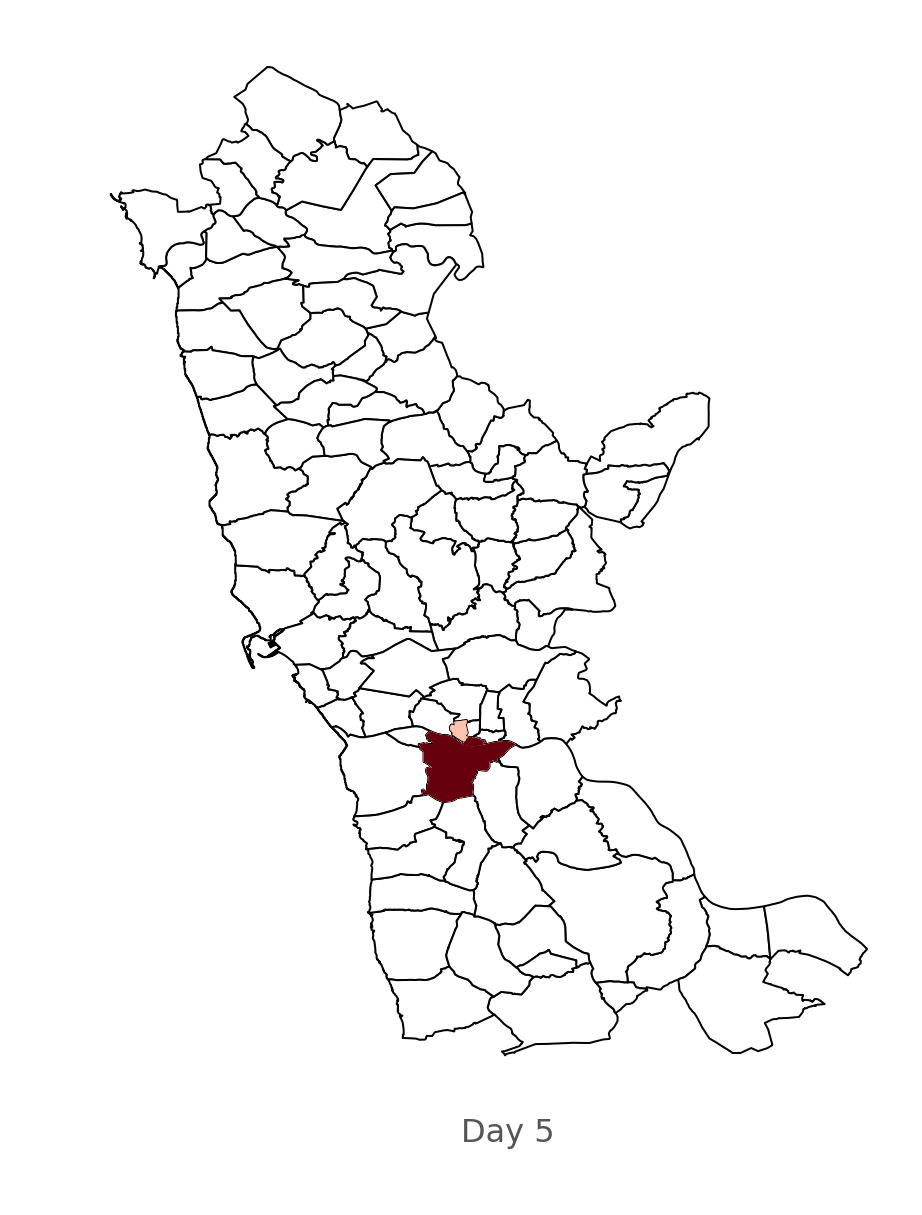

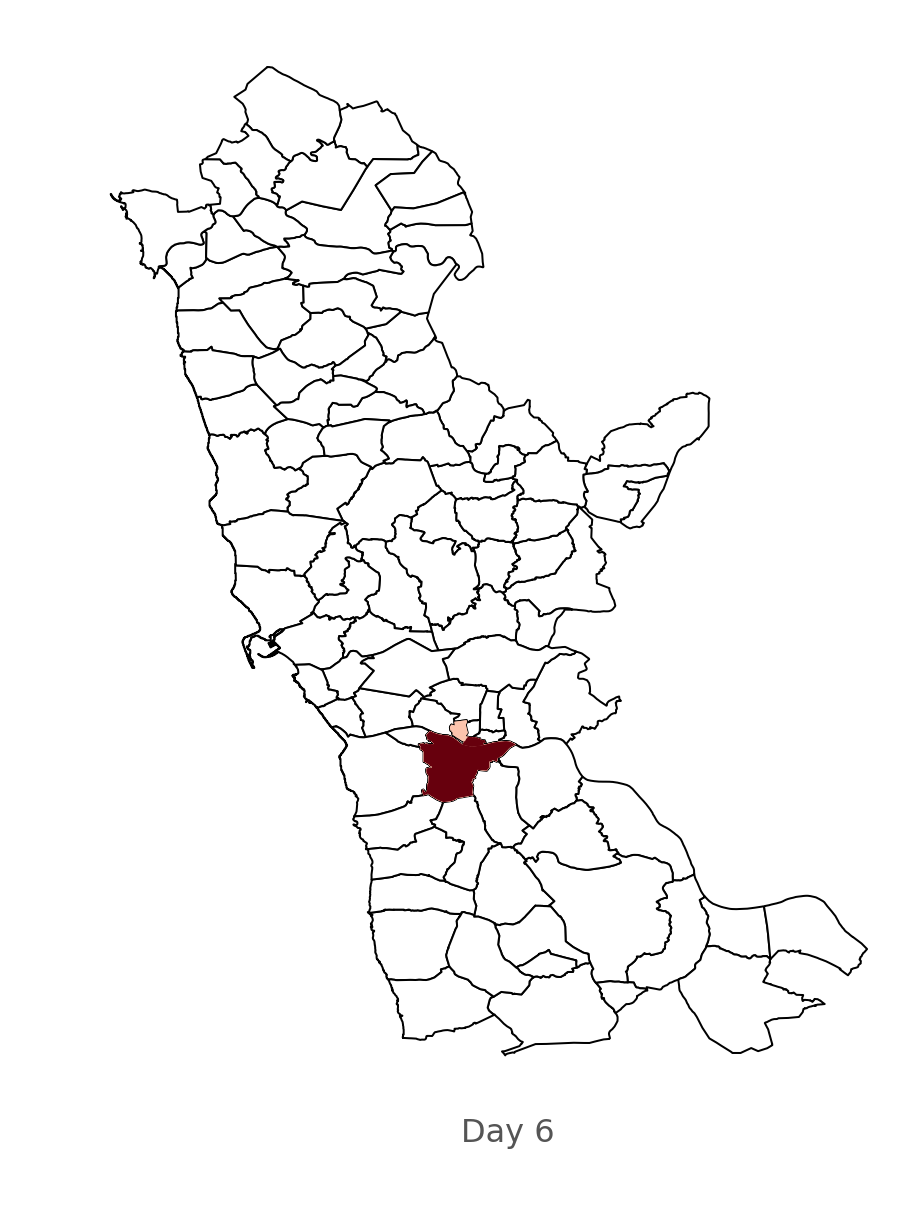

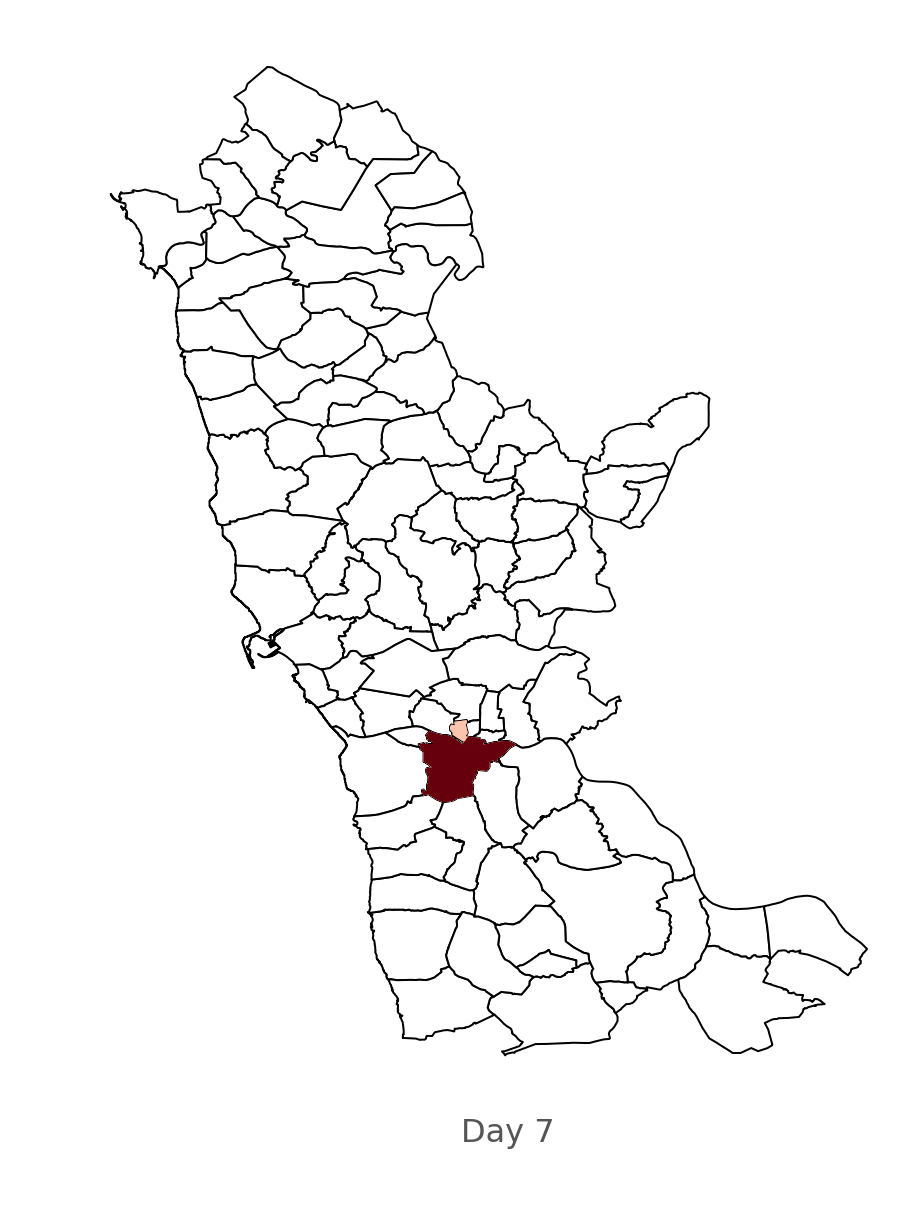

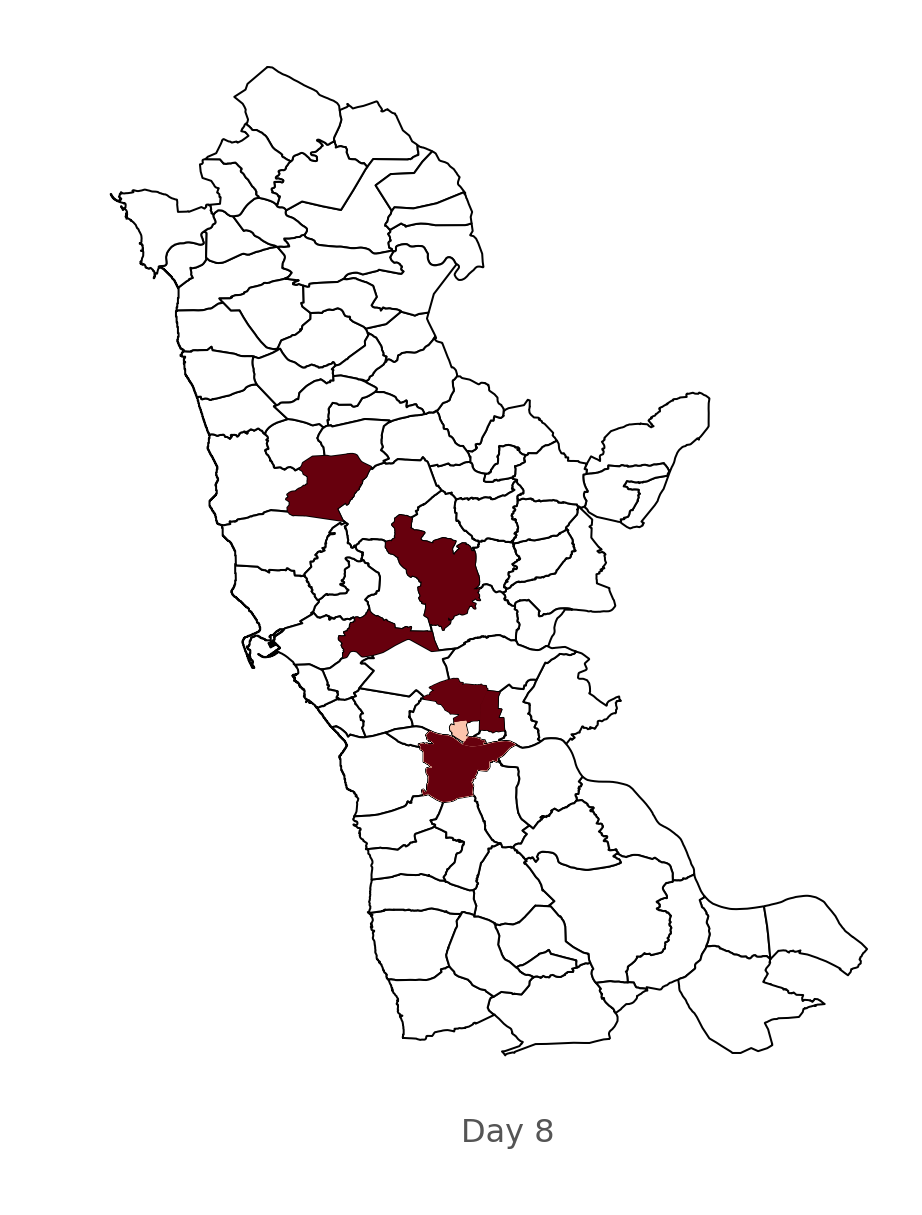

In [15]:
set_matplotlib_formats('retina')

couple['rel_count']=1

for day in list(range(min(couple.index.unique()),max(couple.index.unique())+1)):

    list_ = list(range(day))
    list_.remove(0)
    

    fig, ax1 = plt.subplots(ncols=1, figsize=(10, 10), sharex=True, sharey=True)
   
    # Plot
    portugal.plot(ax=ax1, color='white', edgecolor='black')
    if day != 1:
        if day != 2:
            #list_.remove(max(list_))
            couple.loc[list_].plot(ax=ax1, column='rel_count', cmap='Reds', vmin=-1, vmax=8)
            couple.loc[day].plot(ax=ax1, column='rel_day2', cmap='Reds', vmin=-1, vmax=day)
            
        else:
            couple.loc[1].plot(ax=ax1, column='rel_count', cmap='Reds', vmin=-1, vmax=8)
            couple.loc[2].plot(ax=ax1, column='rel_day2', cmap='Reds', vmin=-1, vmax=day)
    else:
        couple.loc[1].plot(ax=ax1, column='rel_day2', cmap='Reds', vmin=-2, vmax=day)

        

    #ax1.set_title('Data Stories: Two tourists in Lisbon', fontdict={'fontsize': 20, 'fontweight' : 3})
    ax1.annotate('Day %s' % (day), xy=(0.5, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=16, color='#555555')
    ax1.axis('off')



geopandas.geodataframe.GeoDataFrame

In [ ]:
couple_story = pd.read_sql_query(query,con=connection)[['event_date','client_id','centroide_latitude','centroide_longitude','label']]
couple_story = couple_story[~couple_story['centroide_latitude'].isnull()]
couple_story = couple_story[~couple_story['client_id'].isnull()]
couple_story = couple_story.drop_duplicates()
couple_story['client_id'] = couple_story['client_id'].astype(int)
#couple_story['event_date'] = pd.to_datetime(couple_story['event_date'])
couple_story['day'] = couple_story['event_date'].dt.day
couple_story['hour'] = couple_story['event_date'].dt.hour
couple_story['minute'] = couple_story['event_date'].dt.minute
couple_story['rel_day'] = (couple_story['day'] - min(couple_story['day'])+1).astype(int)



In [ ]:
places = couple_story.sort_values('event_date').groupby('rel_day')['label'].unique().to_frame()

print('Places visited each day (per order):')
for day in list(range(1,9)):
    print('Day %s:' % day, places.loc[day]['label'] )


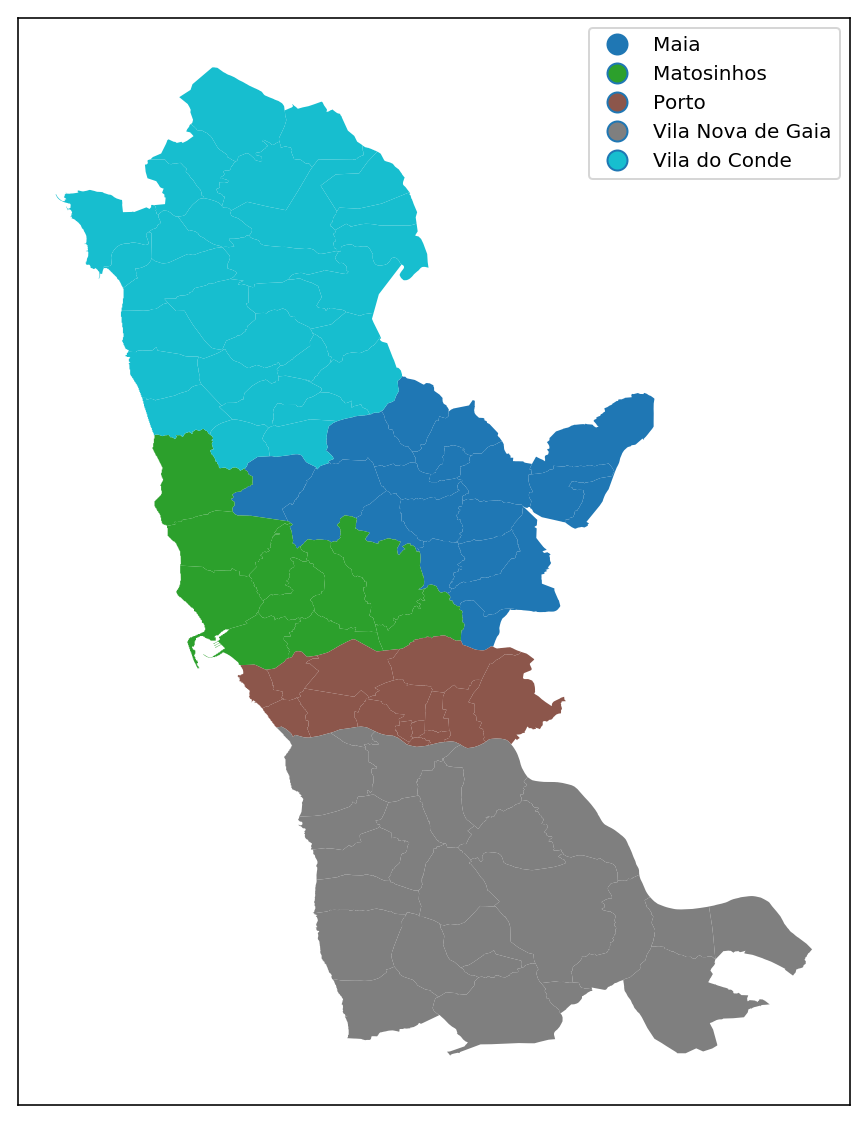

In [23]:
set_matplotlib_formats('retina')
fig = portugal.plot(column='concelho', legend='concelho', figsize=(10, 10))
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)